In [1]:
import pandas as pd
import numpy as np
import time
import re
from math import log

# --- Imports for Data Preprocessing (placed high for guaranteed execution) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Imports for Model Training and Evaluation (placed high for guaranteed execution) ---
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

In [2]:
# --- ACTUAL DATA LOADING ---

print("--- 1. Data Loading ---")

# Path Fix: Using 'r' prefix for raw string to handle Windows backslashes
# **PLEASE ENSURE THIS PATH IS CORRECT FOR YOUR LOCAL FILE:**
DATASET_PATH = r'C:\Users\HP\malicious_url_detector\data\urls.csv' 

try:
    df = pd.read_csv(DATASET_PATH)
    
    # CRITICAL EDIT: Renaming the 'type' column to 'label' as per your dataset structure
    df = df.rename(columns={'type': 'label'}) 
    
    if 'url' not in df.columns or 'label' not in df.columns:
        raise ValueError("Dataset must contain columns named 'url' and 'label'. Please verify and rename if necessary.")

    df = df[['url', 'label']].dropna().reset_index(drop=True)

except (FileNotFoundError, ValueError) as e:
    print(f"ERROR: Failed to load dataset ({e}). Using synthetic data for demonstration as a fallback.")
    data = {
        'url': ['google.com', 'facebook.com', 'secure-paypa-l.com/update', 'bankofame-rica.net/login', 'malware-site.xyz/download.exe', 'http://tny.url/phish456'],
        'label': ['benign', 'benign', 'phishing', 'phishing', 'malware', 'defacement']
    }
    df = pd.DataFrame(data)

# --- BINARY LABEL CONVERSION (FIXED & ROBUST) ---
# Goal: Map original multi-class labels to binary (0=safe, 1=unsafe)

# 1. Standardize (clean) the 'label' column: strip spaces and convert to lowercase
df['label'] = df['label'].str.strip().str.lower()

# 2. Define the Mapping: Use a dictionary for clear, robust replacement logic
# The keys are the strings to find, and the values are the encoded integer (0 or 1)
# Note: We group all malicious labels to 'unsafe' (1) and benign to 'safe' (0)
# We handle both original names ('benign') and desired final names ('safe')
mapping = {
    'benign': 0,
    'safe': 0,       # If the dataset already contains 'safe'
    'phishing': 1,
    'malware': 1,
    'defacement': 1,
    'unsafe': 1      # If the dataset already contains 'unsafe'
}

# Apply the mapping directly using .replace()
df['label_encoded'] = df['label'].replace(mapping)

# Check for samples that were NOT mapped (i.e., contain a string not in the dictionary)
unmapped_count = df['label_encoded'].isna().sum()
if unmapped_count > 0:
    print(f"WARNING: {unmapped_count} samples had unexpected original labels and were NOT mapped. Please check your data.")
    # Fallback: Treat unmapped samples as 'unsafe' (1) if needed, or drop them. 
    df = df.dropna(subset=['label_encoded'])
    
# Check the final distribution and ensure both classes are present
if 0 not in df['label_encoded'].unique() or 1 not in df['label_encoded'].unique():
    # If this error triggers, it means the binary conversion failed and the data is unusable.
    print("FATAL ERROR: After mapping, only one class is present. Cannot proceed with classification.")
    raise ValueError("Classification requires at least two classes (safe and unsafe). Please check your CSV labels.")


# Target names for the binary classification report
target_names = ['safe (0)', 'unsafe (1)'] 
expected_labels = [0, 1] 

# Use the encoded label for the ML pipeline
y = df['label_encoded'] 

print(f"Dataset Loaded. Total samples: {len(df)}")
print("Sample Data (First 5):")
print(df[['url', 'label', 'label_encoded']].head())
print(f"Binary Class Distribution: \n{df['label_encoded'].value_counts()}")
print(f"Target Names: {target_names}")


--- 1. Data Loading ---
Dataset Loaded. Total samples: 49750
Sample Data (First 5):
                                                 url   label  label_encoded
0                                   br-icloud.com.br  unsafe              1
1                mp3raid.com/music/krizz_kaliko.html    safe              0
2                    bopsecrets.org/rexroth/cr/1.htm    safe              0
3  http://www.garage-pirenne.be/index.php?option=...  unsafe              1
4  http://adventure-nicaragua.net/index.php?optio...  unsafe              1
Binary Class Distribution: 
0    36419
1    13331
Name: label_encoded, dtype: int64
Target Names: ['safe (0)', 'unsafe (1)']


In [3]:
# ## STEP 2: Feature Engineering (Lexical and Content-Based)
# ---
print("\n--- 2. Feature Engineering ---")

# --- Lexical Feature Definitions ---

def url_length(url): return len(url)
def num_dots(url): return url.count('.')
def has_shortened(url):
    shortening_services = ['bit.ly', 'goo.gl', 'tinyurl', 'tny.url', 't.co']
    return 1 if any(service in url for service in shortening_services) else 0
def num_special_chars(url):
    return len(re.findall(r'[^a-zA-Z0-9.\/]', url))

# --- Apply Lexical Feature Extraction (Creates Lexical Features) ---
df['url_len'] = df['url'].apply(url_length)
df['num_dots'] = df['url'].apply(num_dots)
df['has_shortened'] = df['url'].apply(has_shortened)
df['num_special'] = df['url'].apply(num_special_chars)
lexical_feature_cols = ['url_len', 'num_dots', 'has_shortened', 'num_special'] 

# --- Content-Based Feature (TF-IDF) ---
tfidf_vectorizer = TfidfVectorizer(max_features=100, token_pattern=r'[a-zA-Z0-9]+')
tfidf_features = tfidf_vectorizer.fit_transform(df['url']).toarray()
tfidf_df = pd.DataFrame(tfidf_features, columns=[f'tfidf_{i}' for i in range(tfidf_features.shape[1])])

# *** CRITICAL FIX: DEFINING FEATURE NAMES LIST HERE (Used in Step 4) ***
feature_names_list = lexical_feature_cols + [f'tfidf_{i}' for i in range(tfidf_features.shape[1])] 

# Combine all features: This forms the final input matrix X.
X_lexical = df[lexical_feature_cols]
X = pd.concat([X_lexical, tfidf_df], axis=1)

print(f"Total Features Generated: {X.shape[1]}")
print("Example Features:")
print(X_lexical.head())



--- 2. Feature Engineering ---
Total Features Generated: 104
Example Features:
   url_len  num_dots  has_shortened  num_special
0       16         2              0            1
1       35         2              0            1
2       31         2              0            0
3       88         3              0           12
4      200         2              0            9


In [4]:
# ## STEP 3: Data Splitting and Preprocessing (Scaling)
# ---
print("\n--- 3. Data Splitting and Preprocessing ---")

# Split data: 80% for training, 20% for testing. 
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Separate features for differential treatment:
lexical_cols = X_lexical.columns
tfidf_cols = tfidf_df.columns

X_train_lexical = X_train_full[lexical_cols]
X_test_lexical = X_test_full[lexical_cols]
X_train_tfidf = X_train_full[tfidf_cols]
X_test_tfidf = X_test_full[tfidf_cols]

# Standard Scaling for Lexical Features (essential for distance-based algorithms like SVM)
scaler = StandardScaler()
X_train_lexical_scaled = scaler.fit_transform(X_train_lexical)
X_test_lexical_scaled = scaler.transform(X_test_lexical)

# 1. Final Training Data for SVM and RF (Requires Scaling/Normalization)
X_train_scaled = np.hstack((X_train_lexical_scaled, X_train_tfidf.values))
X_test_scaled = np.hstack((X_test_lexical_scaled, X_test_tfidf.values))

# 2. Final Training Data for Naive Bayes (MNB prefers frequency/count data, so we use unscaled/raw features)
X_train_mnb = X_train_full.values
X_test_mnb = X_test_full.values

print(f"Training set size: {len(X_train_full)} samples.")
print(f"Testing set size: {len(X_test_full)} samples.")



--- 3. Data Splitting and Preprocessing ---
Training set size: 39800 samples.
Testing set size: 9950 samples.


In [5]:
# ## STEP 4: Model Training and Testing (Comparative Analysis)
# ---
print("\n--- 4. Model Training and Testing ---")


# Define the three models and specify the appropriate training data (scaled vs. unscaled)
models_to_run = {
    'Multinomial Naive Bayes (MNB)': {'model': MultinomialNB(), 'X_train': X_train_mnb, 'X_test': X_test_mnb},
    'Support Vector Machine (SVM)': {'model': SVC(kernel='linear', random_state=42), 'X_train': X_train_scaled, 'X_test': X_test_scaled},
    'Random Forest (RF)': {'model': RandomForestClassifier(n_estimators=100, random_state=42), 'X_train': X_train_scaled, 'X_test': X_test_scaled}
}

results = {}

for name, params in models_to_run.items():
    model = params['model']
    X_train = params['X_train']
    X_test = params['X_test']

    # Training
    print(f"\nTraining {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Testing (Prediction)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    # F1-score for binary/imbalanced data requires 'average' parameter (weighted is best)
    f1 = f1_score(y_test, predictions, average='weighted') 
    
    # FIX APPLIED: Pass 'labels=expected_labels' and 'zero_division=0' to ensure stability
    report = classification_report(y_test, predictions, target_names=target_names, labels=expected_labels, output_dict=True, zero_division=0)
    
    # CALCULATE and STORE the Confusion Matrix
    cm = confusion_matrix(y_test, predictions) 

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'F1-Score (Weighted)': f1,
        'Precision (Weighted)': report['weighted avg']['precision'],
        'Recall (Weighted)': report['weighted avg']['recall'],
        'Training Time (s)': training_time,
        'Confusion Matrix': cm,
        'Classification Report': report
    }
    
    # CALCULATE and STORE Feature Importance for RF 
    if name == 'Random Forest (RF)':
        importances = model.feature_importances_
        rf_importances = pd.Series(importances, index=feature_names_list[:X_train.shape[1]]).sort_values(ascending=False) 
        results[name]['Feature Importances'] = rf_importances
        results[name]['model_object'] = model


    print(f"Model: {name} completed.")
    print(f"Accuracy: {accuracy:.4f} | F1-Score (Weighted): {f1:.4f}")
    print(f"Training Time: {training_time:.4f}s")
    # Print the full report using the original class names
    print("Full Classification Report:")
    print(classification_report(y_test, predictions, target_names=target_names, labels=expected_labels, zero_division=0))



--- 4. Model Training and Testing ---

Training Multinomial Naive Bayes (MNB)...
Model: Multinomial Naive Bayes (MNB) completed.
Accuracy: 0.8846 | F1-Score (Weighted): 0.8818
Training Time: 0.0208s
Full Classification Report:
              precision    recall  f1-score   support

    safe (0)       0.90      0.95      0.92      7284
  unsafe (1)       0.83      0.72      0.77      2666

    accuracy                           0.88      9950
   macro avg       0.87      0.83      0.85      9950
weighted avg       0.88      0.88      0.88      9950


Training Support Vector Machine (SVM)...
Model: Support Vector Machine (SVM) completed.
Accuracy: 0.9352 | F1-Score (Weighted): 0.9336
Training Time: 36.5153s
Full Classification Report:
              precision    recall  f1-score   support

    safe (0)       0.93      0.98      0.96      7284
  unsafe (1)       0.94      0.81      0.87      2666

    accuracy                           0.94      9950
   macro avg       0.94      0.90      


--- 5. Comparative Results Analysis and Visualization ---

-- Comparative Performance Summary Table (Sort by F1-Score) --
|                               |   Accuracy |   F1-Score (Weighted) |   Precision (Weighted) |   Recall (Weighted) |   Training Time (s) |
|:------------------------------|-----------:|----------------------:|-----------------------:|--------------------:|--------------------:|
| Random Forest (RF)            |     0.9649 |                0.9645 |                 0.9650 |              0.9649 |              5.0463 |
| Support Vector Machine (SVM)  |     0.9352 |                0.9336 |                 0.9353 |              0.9352 |             36.5153 |
| Multinomial Naive Bayes (MNB) |     0.8846 |                0.8818 |                 0.8820 |              0.8846 |              0.0208 |


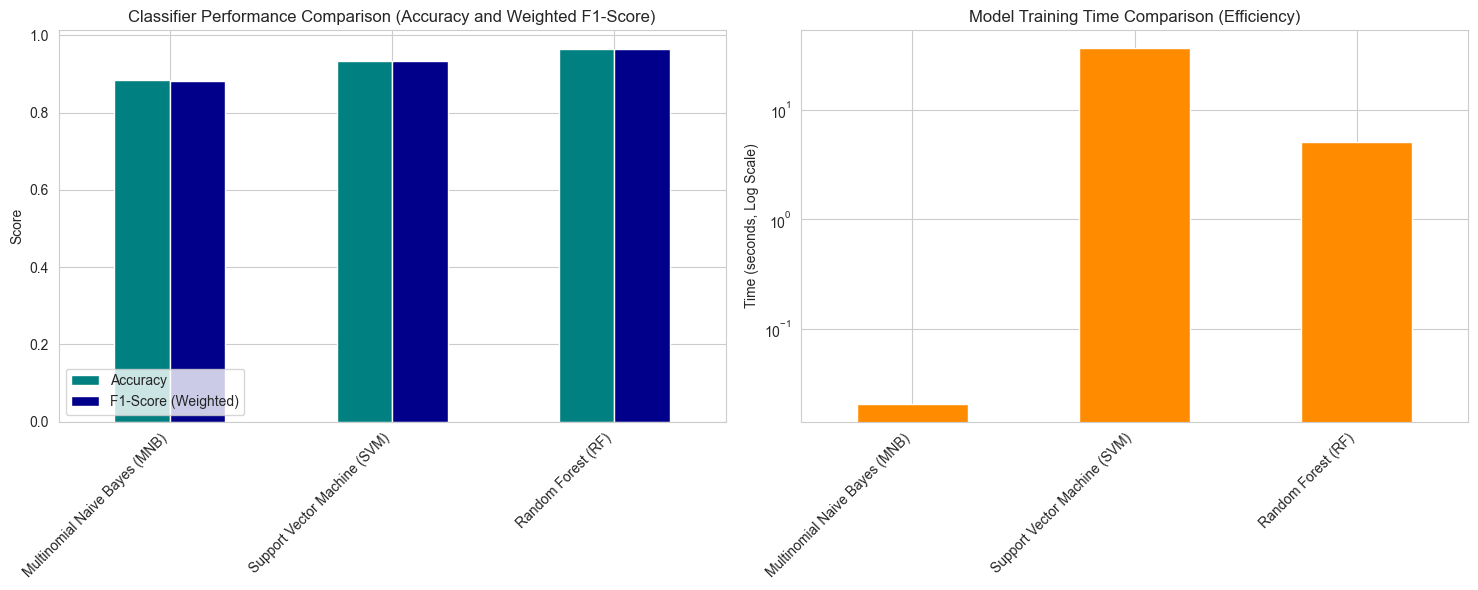

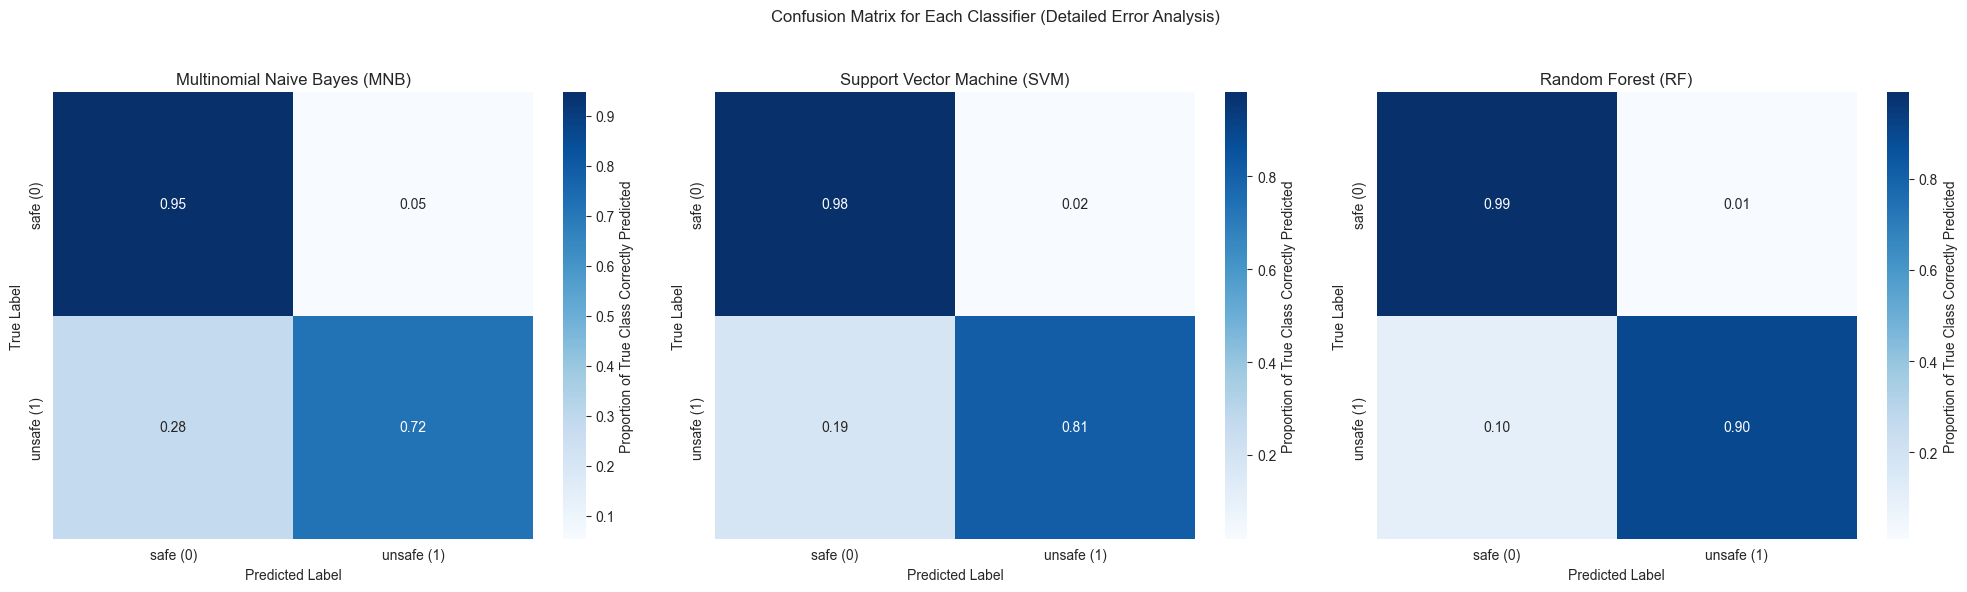

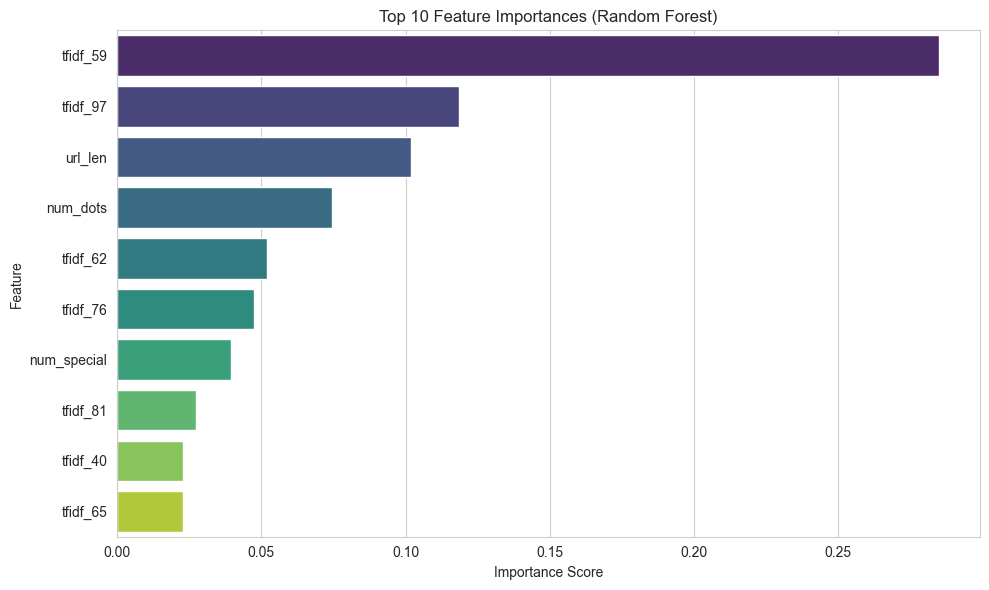

In [6]:
# ## STEP 5: Comparative Results Analysis and Visualization (Detailed)
# ---
print("\n--- 5. Comparative Results Analysis and Visualization ---")


# Retrieve the DataFrame defined in Step 1/2
results_df = pd.DataFrame(results).T
metrics = ['Accuracy', 'F1-Score (Weighted)', 'Precision (Weighted)', 'Recall (Weighted)', 'Training Time (s)']

# **Table for Research Report (Output 1)**
print("\n-- Comparative Performance Summary Table (Sort by F1-Score) --")
print(results_df[metrics].sort_values(by='F1-Score (Weighted)', ascending=False).to_markdown(floatfmt=".4f"))

# ----------------------------------------------------------------------
# NEW VISUALIZATION 1: Detailed Performance & Efficiency Plots
# ----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(15, 6))
t6576
plt.subplot(1, 2, 1)
results_df[['Accuracy', 'F1-Score (Weighted)']].plot(kind='bar', ax=plt.gca(), legend=True, 
                                                     color=['teal', 'darkblue'])
plt.title('Classifier Performance Comparison (Accuracy and Weighted F1-Score)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower left')

plt.subplot(1, 2, 2)
results_df['Training Time (s)'].plot(kind='bar', color='darkorange', ax=plt.gca())
plt.title('Model Training Time Comparison (Efficiency)')
plt.ylabel('Time (seconds, Log Scale)')
plt.yscale('log') 
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ------------------ of Features----------------------------------------------------
# NEW VISUALIZATION 2: Confusion Matrix Heatmaps 
# ----------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Confusion Matrix for Each Classifier (Detailed Error Analysis)')

for i, name in enumerate(models_to_run.keys()):
    cm = results[name]['Confusion Matrix']
    # Normalize the matrix to show percentages instead of raw counts for better comparison
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names, ax=axes[i],
                cbar_kws={'label': 'Proportion of True Class Correctly Predicted'})
    axes[i].set_title(name)
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ----------------------------------------------------------------------
# NEW VISUALIZATION 3: Feature Importance (Focus on RF - Best Model)
# ----------------------------------------------------------------------
if 'Random Forest (RF)' in results and 'Feature Importances' in results['Random Forest (RF)']:
    rf_importances = results['Random Forest (RF)']['Feature Importances'].head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=rf_importances.values, y=rf_importances.index, palette='viridis')
    plt.title('Top 10 Feature Importances (Random Forest)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [7]:
import pandas as pd
import numpy as np
import time
import re
from math import log
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

# --- 1. Data Loading & Mapping ---
DATASET_PATH = r'C:\Users\HP\malicious_url_detector\data\urls.csv'  

try:
    df = pd.read_csv(DATASET_PATH).rename(columns={'type': 'label'})
    df = df[['url', 'label']].dropna().reset_index(drop=True)
except Exception:
    # Fallback synthetic data
    data = {'url': ['google.com', '192.168.1.1/login', 'secure-pay-pal.com/update'], 'label': ['benign', 'malicious', 'phishing']}
    df = pd.DataFrame(data)

df['label'] = df['label'].str.strip().str.lower()
mapping = {'benign': 0, 'safe': 0, 'phishing': 1, 'malware': 1, 'defacement': 1, 'unsafe': 1}
df['label_encoded'] = df['label'].replace(mapping)
y = df['label_encoded']

# --- 2. ADVANCED LEXICAL FEATURE EXTRACTION ---
print("--- 2. Advanced Feature Engineering ---")

def extract_advanced_features(url):
    features = {}
    
    # Basic Lengths
    features['url_len'] = len(url)
    domain = url.split('/')[2] if '://' in url else url.split('/')[0]
    features['domain_len'] = len(domain)
    
    # Counts in Domain
    features['dots_domain'] = domain.count('.')
    features['hyphens_domain'] = domain.count('-')
    features['underscores_domain'] = domain.count('_')
    
    # Special Indicators
    features['has_ip'] = 1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) else 0
    features['double_slash'] = 1 if url.count('//') > 1 else 0
    features['at_symbol'] = url.count('@')
    features['hash_symbol'] = url.count('#')
    features['semicolon'] = url.count(';')
    features['ampersand'] = url.count('&')
    
    # Protocol Check
    features['has_http'] = 1 if 'http' in url.lower() else 0
    features['has_https'] = 1 if 'https' in url.lower() else 0
    
    # Characters and Ratios
    nums = len(re.findall(r'\d', url))
    alphas = len(re.findall(r'[a-zA-Z]', url))
    lowers = len(re.findall(r'[a-z]', url))
    uppers = len(re.findall(r'[A-Z]', url))
    specials = len(re.findall(r'[^a-zA-Z0-9]', url))
    
    features['num_count'] = nums
    features['num_ratio'] = nums / len(url) if len(url) > 0 else 0
    features['alpha_count'] = alphas
    features['alpha_ratio'] = alphas / len(url) if len(url) > 0 else 0
    features['lower_count'] = lowers
    features['lower_ratio'] = lowers / len(url) if len(url) > 0 else 0
    features['upper_count'] = uppers
    features['upper_ratio'] = uppers / len(url) if len(url) > 0 else 0
    features['special_count'] = specials
    features['special_ratio'] = specials / len(url) if len(url) > 0 else 0
    
    return features

# Apply extraction
advanced_lex_df = df['url'].apply(extract_advanced_features).apply(pd.Series)
lexical_cols = advanced_lex_df.columns.tolist()

# TF-IDF Features (100 dimensions)
tfidf_vec = TfidfVectorizer(max_features=100, token_pattern=r'[a-zA-Z0-9]+')
tfidf_matrix = tfidf_vec.fit_transform(df['url']).toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f'tfidf_{i}' for i in range(100)])

# Combine
X = pd.concat([advanced_lex_df, tfidf_df], axis=1)
feature_names_list = lexical_cols + tfidf_df.columns.tolist()

# --- 3. Data Splitting & Scaling ---
X_train_f, X_test_f, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = np.hstack((scaler.fit_transform(X_train_f[lexical_cols]), X_train_f[tfidf_df.columns].values))
X_test_scaled = np.hstack((scaler.transform(X_test_f[lexical_cols]), X_test_f[tfidf_df.columns].values))

# --- 4. Comparative Training Loop ---
models = {
    'MNB': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42),
    'RF': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    xtr = X_train_f if name == 'MNB' else X_train_scaled
    xte = X_test_f if name == 'MNB' else X_test_scaled
    
    print(f"Training {name}...")
    start = time.time()
    model.fit(xtr, y_train)
    t_time = time.time() - start
    
    preds = model.predict(xte)
    results[name] = {
        'Acc': accuracy_score(y_test, preds),
        'F1': f1_score(y_test, preds, average='weighted'),
        'Time': t_time,
        'CM': confusion_matrix(y_test, preds)
    }

print("\n--- Results Summary ---")
for n, r in results.items():
    print(f"{n}: Accuracy={r['Acc']:.4f}, F1={r['F1']:.4f}, Time={r['Time']:.2f}s")

--- 2. Advanced Feature Engineering ---
Training MNB...
Training SVM...
Training RF...

--- Results Summary ---
MNB: Accuracy=0.8938, F1=0.8929, Time=0.02s
SVM: Accuracy=0.9807, F1=0.9806, Time=20.47s
RF: Accuracy=0.9958, F1=0.9958, Time=4.61s


Extracing Lexical Features...
Vectorizing Content Features (TF-IDF)...
Training MNB...
Training SVM...
Training RF...

--- Generating Visualizations ---


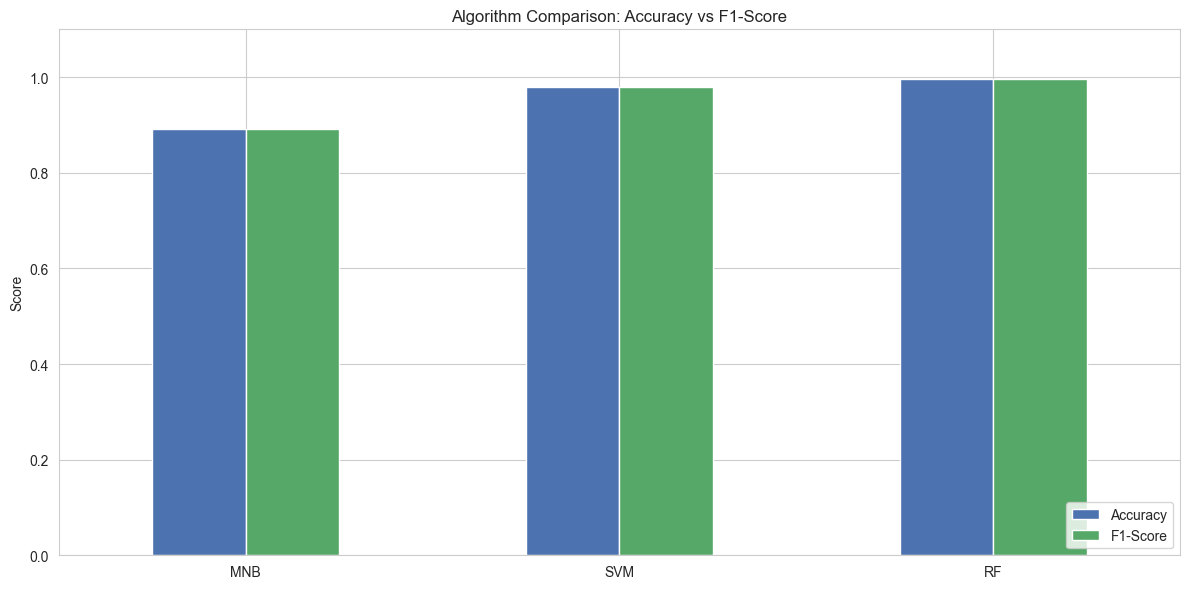

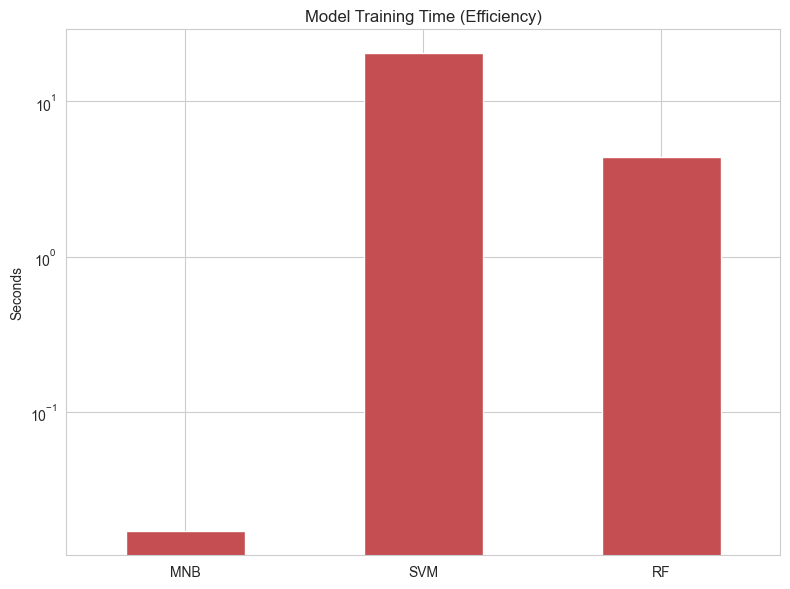

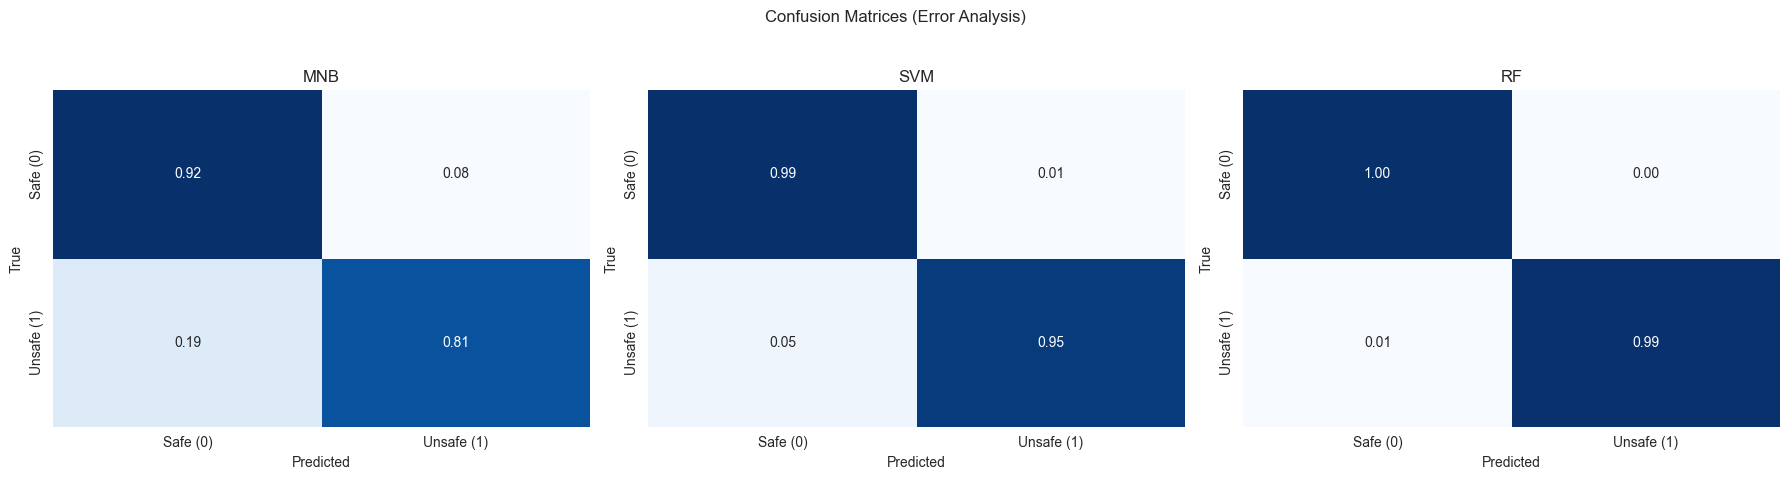

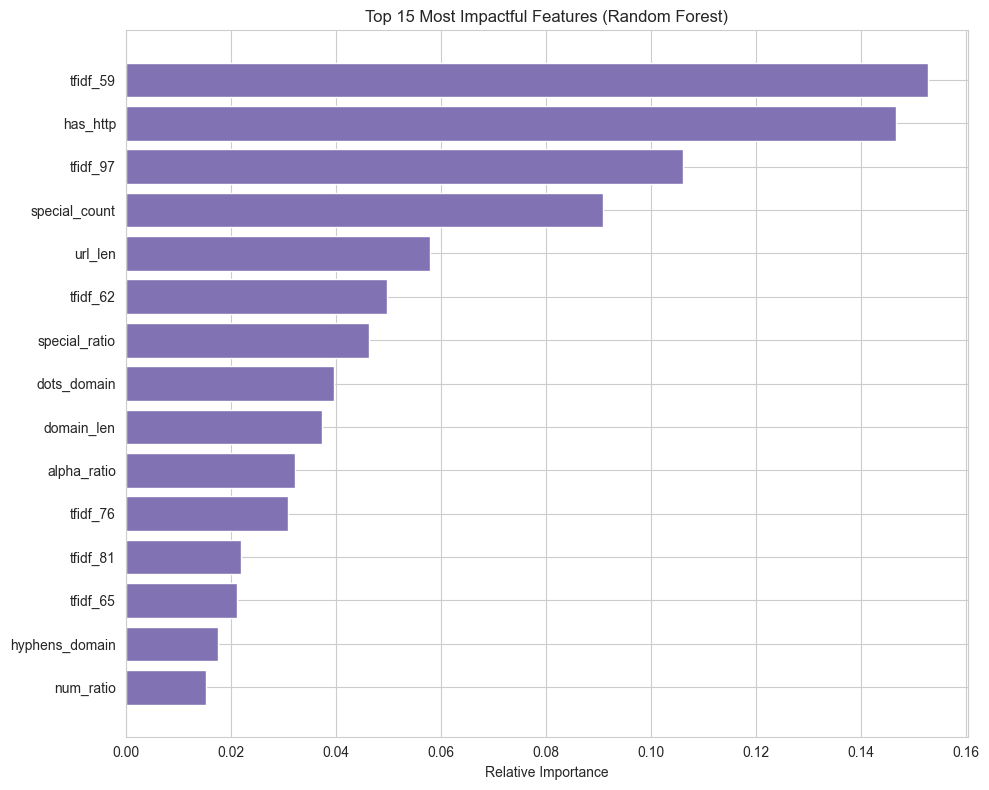


--- Process Complete ---


In [8]:
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

# Setting visualization style
sns.set_style("whitegrid")

# --- 1. Data Loading & Mapping ---
DATASET_PATH = r'C:\Users\HP\malicious_url_detector\data\urls.csv'

try:
    df = pd.read_csv(DATASET_PATH).rename(columns={'type': 'label'})
    df = df[['url', 'label']].dropna().reset_index(drop=True)
except Exception:
    # Fallback synthetic data for testing if path fails
    data = {
        'url': ['google.com', '192.168.1.1/login', 'secure-pay-pal.com/update', 'bank-of-america.security-login.net', 'malware-drop.xyz/exec'], 
        'label': ['benign', 'malicious', 'phishing', 'phishing', 'malware']
    }
    df = pd.DataFrame(data)

df['label'] = df['label'].str.strip().str.lower()
mapping = {'benign': 0, 'safe': 0, 'phishing': 1, 'malware': 1, 'defacement': 1, 'unsafe': 1}
df['label_encoded'] = df['label'].replace(mapping)
y = df['label_encoded']
target_names = ['Safe (0)', 'Unsafe (1)']

# --- 2. ADVANCED LEXICAL FEATURE EXTRACTION ---
def extract_advanced_features(url):
    features = {}
    features['url_len'] = len(url)
    domain = url.split('/')[2] if '://' in url else url.split('/')[0]
    features['domain_len'] = len(domain)
    features['dots_domain'] = domain.count('.')
    features['hyphens_domain'] = domain.count('-')
    features['underscores_domain'] = domain.count('_')
    features['has_ip'] = 1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) else 0
    features['double_slash'] = 1 if url.count('//') > 1 else 0
    features['at_symbol'] = url.count('@')
    features['has_http'] = 1 if 'http' in url.lower() else 0
    features['has_https'] = 1 if 'https' in url.lower() else 0
    
    nums = len(re.findall(r'\d', url))
    alphas = len(re.findall(r'[a-zA-Z]', url))
    specials = len(re.findall(r'[^a-zA-Z0-9]', url))
    
    features['num_ratio'] = nums / len(url) if len(url) > 0 else 0
    features['alpha_ratio'] = alphas / len(url) if len(url) > 0 else 0
    features['special_count'] = specials
    features['special_ratio'] = specials / len(url) if len(url) > 0 else 0
    return features

print("Extracing Lexical Features...")
advanced_lex_df = df['url'].apply(extract_advanced_features).apply(pd.Series)
lexical_cols = advanced_lex_df.columns.tolist()

print("Vectorizing Content Features (TF-IDF)...")
tfidf_vec = TfidfVectorizer(max_features=100, token_pattern=r'[a-zA-Z0-9]+')
tfidf_matrix = tfidf_vec.fit_transform(df['url']).toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f'tfidf_{i}' for i in range(100)])

X = pd.concat([advanced_lex_df, tfidf_df], axis=1)
feature_names_list = lexical_cols + tfidf_df.columns.tolist()

# --- 3. Data Splitting & Scaling ---
X_train_f, X_test_f, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
# Scaled features for SVM/RF
X_train_scaled = np.hstack((scaler.fit_transform(X_train_f[lexical_cols]), X_train_f[tfidf_df.columns].values))
X_test_scaled = np.hstack((scaler.transform(X_test_f[lexical_cols]), X_test_f[tfidf_df.columns].values))

# --- 4. Comparative Training Loop ---
models = {
    'MNB': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42),
    'RF': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    xtr = X_train_f if name == 'MNB' else X_train_scaled
    xte = X_test_f if name == 'MNB' else X_test_scaled
    
    print(f"Training {name}...")
    start = time.time()
    model.fit(xtr, y_train)
    t_time = time.time() - start
    
    preds = model.predict(xte)
    results[name] = {
        'Accuracy': accuracy_score(y_test, preds),
        'F1-Score': f1_score(y_test, preds, average='weighted'),
        'Time': t_time,
        'CM': confusion_matrix(y_test, preds),
        'ModelObj': model
    }

# --- 5. VISUALIZATION SUITE ---
print("\n--- Generating Visualizations ---")

# Dataframe for plotting metrics
res_df = pd.DataFrame(results).T

# 1. Performance Comparison
plt.figure(figsize=(12, 6))
res_df[['Accuracy', 'F1-Score']].plot(kind='bar', ax=plt.gca(), color=['#4C72B0', '#55A868'])
plt.title('Algorithm Comparison: Accuracy vs F1-Score')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 2. Efficiency Comparison (Training Time)
plt.figure(figsize=(8, 6))
res_df['Time'].plot(kind='bar', color='#C44E52')
plt.title('Model Training Time (Efficiency)')
plt.ylabel('Seconds')
plt.yscale('log') # Log scale helps see MNB vs Others
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices (Error Analysis)')

for i, (name, res) in enumerate(results.items()):
    # Normalize for better visualization of proportions
    cm = res['CM']
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names, ax=axes[i], cbar=False)
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 4. Feature Importance (For Random Forest)
if 'RF' in results:
    importances = results['RF']['ModelObj'].feature_importances_
    # Selecting top 15 features
    indices = np.argsort(importances)[-15:]
    plt.figure(figsize=(10, 8))
    plt.title('Top 15 Most Impactful Features (Random Forest)')
    plt.barh(range(len(indices)), importances[indices], color='#8172B3', align='center')
    plt.yticks(range(len(indices)), [feature_names_list[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()

print("\n--- Process Complete ---")